## NB6. ROF analysis for monthly, annual, seasonal discharge at ocean outles <a id='top'></a>

Use 

1. reach-D19 gauge link ascii
2. D19 flow site geopackage
3. D19 discharge netCDF
4. monthly and yearly flow netCD (history file)

[1. Setupt](#setup)

[2. Loading data](#load_data)

- monthly history files (directory from CESM or postprocessed) from archive. 

- Reference data is monthly discharge estimates at 922 big river mouths from Dai et al. 2019 data (D19)

[3. Read river, catchment, gauge information](#read_meta)

- xxx

[4. Ocean discharge line plots](#922_rivers)

- total seasonal flow for oceans. 

[5. Maps](#maps)

- Ocean and outlet catchments.


In [1]:
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scripts.utility import load_toml 
from scripts.utility import no_time_variable
from scripts.utility import read_shps
from scripts.utility import get_index_array

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)


The Python version: 3.10.12
xarray 2023.6.0
pandas 2.0.3
geopandas 0.13.2


In [2]:
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
land = cfeature.LAND

-----
### dasks (optional)

In [ ]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(queue='casper', memory='10GB', processes=1)
cluster.scale(jobs=10)

In [ ]:
from dask.distributed import Client
client = Client(cluster)
client

-------------------------
## 1. Analysis setup <a id='setup'></a>

**Please provide CESM case names and ROF grid name**

[go back to top](#top)

In [3]:
# CESM case names and their runoff grid

cases = {
        'f09_f09_rHDMA':'rHDMA',
        #'f09_f09_rHDMAlk_mg17':'rHDMAlk',
        #'f09_f09_rHDMAlk_mg17_dfw':'rHDMAlk_dfw',
        #'f09_f09_rHDMAlk_mg17_irrig':'rHDMAlk_irrig',
        #'f09_f09_mg17':'f09_f09',
        #'f09_f09_mg17_mosart':'f09_f09_mosart',
        }
plot_name = 'routing_methods'

-------------------------
load config files and some parameters 

In [4]:
setup = load_toml('./setup/setup.toml')

main_dir       = setup['archive_dir']     # CESM archive directory
domain_dir     = setup['ancillary_dir']   # ancillary directory including such as ROF domain 
geospatial_dir = setup['geospatial_dir']  # including shapefiles etc
ref_flow_dir   = setup['ref_flow_dir']    # including observed or reference flow data 
syr            = setup['syr']             # analysis start year
eyr            = setup['eyr']             # analysis end year
rof_grid       = setup['rof_grid']        # RO grid meta
catch_gpkg     = setup['catch_gpkg']
reach_gpkg     = setup['reach_gpkg']      # reach geopackage meta
network        = setup['river_network']

time_period = slice(f'{syr}-01-01',f'{eyr}-12-31') # analysis time period
nyrs = eyr-syr+1  # number of years
nmons = nyrs*12   # number of months

In [5]:
oceans_list = ['arctic', 'atlantic', 'indian', 'mediterranean', 'pacific', 'south_china', 'global']

In [6]:
save_gpkg=False

## 2. Loading data <a id='load_data'></a>

[go back to top](#top)

### 2.1. Mmonthly/annual flow netCDFs
- month_data (xr dataset)
- year_data (xr dataset)
- seas_data (xr dataset)

In [7]:
%%time

reachID    = {}
month_data = {}
year_data  = {}
seas_data  = {}
for case, grid_name in cases.items():
    in_dire = os.path.join(main_dir, case, 'rof/hist')
    model  = rof_grid[grid_name]['model']
    domain = rof_grid[grid_name]['domain_nc']
    #monthly
    month_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.month.nc', data_vars='minimal', chunks={'time':12}).sel(time=time_period).load()
    #annual
    year_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.annual.nc', data_vars='minimal', chunks={'time':1}).sel(time=time_period).load()
    #seasonal (compute here instead of reading because of different time period)
    seas_data[case] = month_data[case].groupby('time.month').mean('time')
    vars_no_time = no_time_variable(month_data[case])
    seas_data[case][vars_no_time] = seas_data[case][vars_no_time].isel(month=0, drop=True)
    
    if domain=='None':  #wish domain = None (not string)
        reachID[case] = month_data[case]['reachID'].values 
    else:
        reachID[case] = xr.open_dataset(f'{domain_dir}/{domain}')['reachID'].values

    print(case)

f09_f09_rHDMA
CPU times: user 6.61 s, sys: 3.3 s, total: 9.91 s
Wall time: 23 s


### 2.2 D19 discharge data
- ds_q_obs_mon (xr datasets)
- ds_q_obs_yr (xr datasets)
- dr_q_obs_seasonal (xr datasets)

In [8]:
%%time

# read monthly data
ds_q = xr.open_dataset('%s/D09/coastal-stns-Vol-monthly.updated-May2019.mod.nc'%(ref_flow_dir),decode_times=False)
ds_q['time'] = xr.cftime_range(start='1900-01-01', end='2018-12-01', freq="MS", calendar="standard")

# monthly
ds_q_obs_mon = ds_q['FLOW'].sel(time=time_period)
# compute annual flow from monthly
ds_q_obs_yr = ds_q_obs_mon.resample(time="1A").mean(dim="time")
# compute annual cycle at monthly scale
dr_q_obs_seasonal = ds_q_obs_mon.sel(time=time_period).groupby('time.month').mean('time')

CPU times: user 43.1 ms, sys: 1.34 ms, total: 44.4 ms
Wall time: 87.6 ms


## 3. Reading river, catchment, gauge infomation  <a id='read_meta'></a>

- catchment polygon (geopackage)
- gauge point (geopackage)
- gauge-catchment link (csv)
- outlet reach information (netCDF)

[go back to top](#top)

### 3.1. reach-D19 gauge link csv
- gauge_reach_lnk (dataframe)

In [9]:
gauge_reach_lnk = {}
for case, grid_name in cases.items():
    gauge_reach_lnk[case] = pd.read_csv('%s/D09/D09_925.%s.asc'%(ref_flow_dir, rof_grid[grid_name]['network']))
    if case=='f09_f09_mg17':
        # temporal fix for f09_f09_mg17 run (simulation use 0 360 grid, but gauge-reach link use -180 180 grid
        gauge_reach_lnk['f09_f09_mg17'].loc[gauge_reach_lnk['f09_f09_mg17']['gauge_lon']<0, 'route_id' ] = gauge_reach_lnk['f09_f09_mg17']['route_id'] + 360
        gauge_reach_lnk['f09_f09_mg17'].loc[gauge_reach_lnk['f09_f09_mg17']['gauge_lon']>0, 'route_id' ] = gauge_reach_lnk['f09_f09_mg17']['route_id'] - 360

### 3.2 D19 flow site shapefile
- gauge_shp (dataframe)

In [10]:
%%time

gauge_shp = gpd.read_file(os.path.join(ref_flow_dir, 'D09','geospatial','D09_925.gpkg'))
gauge_shp = gauge_shp[gauge_shp['id']!=9999999]

CPU times: user 195 ms, sys: 0 ns, total: 195 ms
Wall time: 244 ms


In [11]:
%%time

ocean_shp = gpd.read_file(os.path.join(geospatial_dir, 'oceans.gpkg'))

CPU times: user 15.2 s, sys: 366 ms, total: 15.6 s
Wall time: 16.6 s


### 3.3 Read river network information
- riv_ocean (dataframe)

In [12]:
%%time
## read catchment geopackage

grid_name = 'rHDMA'
network_name = rof_grid[grid_name]['network']

cat_gpkg = os.path.join(geospatial_dir, catch_gpkg[network_name]['file_name'])  # geopackage name
id_name_cat = catch_gpkg[network_name]['id_name']                              # reach ID in geopackage
var_list = [id_name_cat]
if 'lk' in grid_name:
    var_list.append('lake')
gdf_cat = read_shps([cat_gpkg], var_list)

Finished reading /glade/campaign/cgd/tss/people/mizukami/ctsm-mizuRoute/geospatial/hdma_global_catch_v2_0.01.gpkg
CPU times: user 44.1 s, sys: 648 ms, total: 44.7 s
Wall time: 47.4 s


In [13]:
%%time
# read river outlet netcdf

riv_ocean_file = os.path.join(domain_dir, 'ntopo_HDMA.v2_outlet_v1.nc')  # network netcdf name
ds_rn_ocean = xr.open_dataset(riv_ocean_file).set_index(seg='seg_id')
riv_ocean = ds_rn_ocean.to_dataframe()
riv_ocean = pd.merge(gdf_cat, riv_ocean, left_on=catch_gpkg[network_name]['id_name'], right_index=True)

CPU times: user 306 ms, sys: 19.7 ms, total: 326 ms
Wall time: 356 ms


### 2.6 Merge gauge, outlet catchment dataframe

- gauge_shp1 (dataframe)

In [14]:
%%time

# Merge gauge_reach lnk (dataframe) into gauge shapefile
gauge_shp1={}
for case, df in gauge_reach_lnk.items():
    #df = df.loc[(df['flag'] == 0)]
    df1 = df.drop(columns=['riv_name'])
    df2 = pd.merge(gauge_shp, df1, how="inner", left_on="id", right_on="gauge_id")
    gauge_shp1[case]  = pd.merge(df2, riv_ocean, how="inner", left_on="route_id", right_on="hruid")

CPU times: user 44.7 ms, sys: 3.78 ms, total: 48.5 ms
Wall time: 49 ms


------
## 4. plot annual cycle for global oceans <a id='24_large_rivers'></a>

[go back to top](#top)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


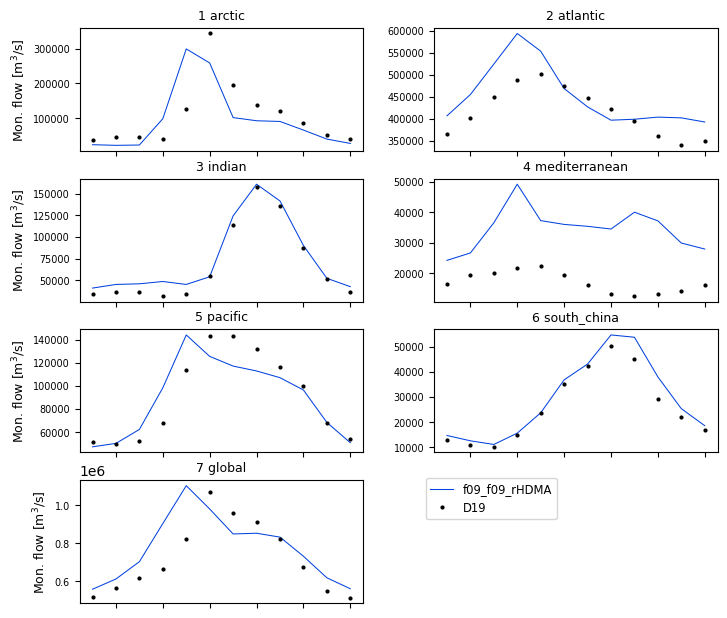

In [27]:
%time

nrows=4; ncols=2
fig, axes = plt.subplots(nrows, ncols, figsize=(7.25, 6.5))
plt.subplots_adjust(top = 0.95, bottom = 0.065, right = 0.98, left = 0.10, hspace=0.225, wspace=0.250)# create some space below the plots by increasing the bottom-value

for ix, ocean_name in enumerate(oceans_list):
    row = ix // 2
    col = ix % 2
    for case in cases:
        grid_name = cases[case]
        
        q_name = rof_grid[grid_name]['flow_name']
        color  = rof_grid[grid_name]['color']
        
        if True:   # means vector
            if ocean_name=='global':
                id_list = gauge_shp1[case]['route_id'].values
            else:
                id_list = gauge_shp1[case][gauge_shp1[case]['ocean']==ocean_name]['route_id'].values
            reach_index = get_index_array(reachID[case], id_list)
            dr_flow = seas_data[case][q_name].isel(seg=reach_index).sum(dim='seg')
            dr_flow.plot(ax=axes[row,col], linestyle='-', c=color, lw=0.75, label=case)

        else:   # means 2d grid 
            # not working yet
            seas_data[case][q_name][:,net_idx[0],net_idx[1]].plot(ax=axes[row,col], linestyle='-', c=color, lw=0.75, label=case)

    # reference data
    if ocean_name=='global':
        id_list = gauge_shp1[case]['id'].values
    else:
        id_list = gauge_shp1[case][gauge_shp1[case]['ocean']==ocean_name]['id'].values
    gauge_index = get_index_array(ds_q['id'].values, id_list)
    dr_obs = dr_q_obs_seasonal.isel(station=gauge_index).sum(dim='station')
    dr_obs.plot(ax=axes[row,col],linestyle='None',marker='o',markersize=2, c='k',label='D19')
    
    axes[row,col].set_title('%d %s'%(ix+1,ocean_name), fontsize=9)
    axes[row,col].set_xlabel('')
    if row < 7:
        axes[row,col].set_xticklabels('')
    if col == 0:
        axes[row,col].set_ylabel('Mon. flow [m$^3$/s]', fontsize=9)
    else: 
        axes[row,col].set_ylabel('')
    axes[row,col].tick_params('both',labelsize='x-small')
    
#Legend- make space below the plot-raise bottom. there will be an label below the second last (bottom middle) ax, thanks to the bbox_to_anchor=(x, y) with a negative y-value. 
axes[row,col].legend(loc='center left', bbox_to_anchor=(1.20, 0.80, 0.75, 0.1), ncol=1, fontsize="small")    

for jx in range(ix+1,nrows*ncols):
    row = jx // 2
    col = jx % 2
    fig.delaxes(axes[row][col])

plt.savefig(f"./Figures/NB6_Fig1_ocean_discharge_season_{plot_name}.png", dpi=200)

##### ------
## 5. Maps <a id='maps'></a>

- ocean basins

[go back to top](#top)

arctic
atlantic
indian
mediterranean
pacific
south_china
na
CPU times: user 1min 21s, sys: 709 ms, total: 1min 22s
Wall time: 1min 28s


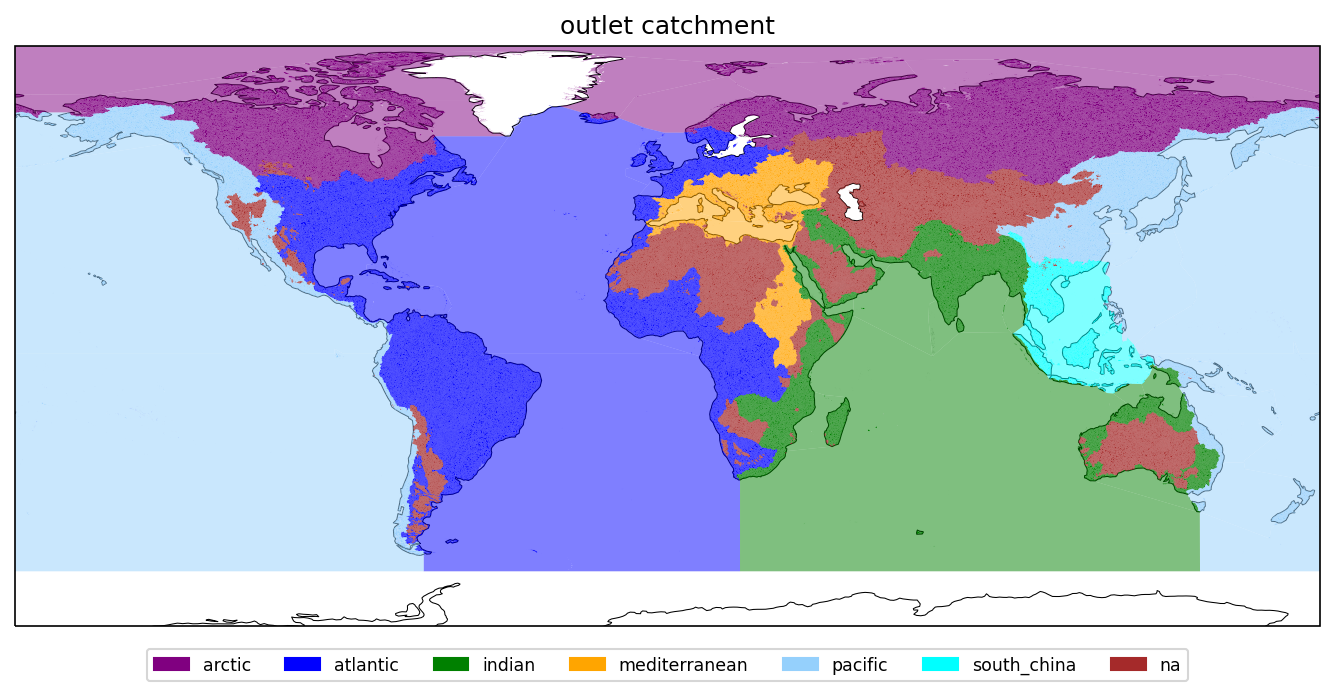

In [16]:
%%time

fig, ax = plt.subplots(1, figsize=(9.0, 5.0),subplot_kw={"projection": ccrs.PlateCarree()}, dpi=150)

cbar_kwrgs = {"shrink":0.9, "pad":0.02, "orientation": "horizontal"}

ocean_colors = {
    "arctic": "purple",
    "atlantic": "blue",
    "indian": "green",
    "mediterranean": "orange",
    "pacific": "xkcd:light blue",
    "south_china": "cyan",
    "na":"brown",
}

for ocean, color in ocean_colors.items():
    riv_ocean[riv_ocean['ocean']==ocean].plot(ax=ax, color=color)
    if ocean!='na':
        ocean_shp[ocean_shp['ocean']==ocean].plot(ax=ax, color=color, alpha=0.5)
    print(ocean)

ax.add_feature(land, facecolor="none", edgecolor='k', lw=0.5, zorder=0)
ax.set_title(f'outlet catchment')
ax.set_xlim(-180, 180)
ax.set_ylim([-75, 85])
    
patch = [mpatches.Patch(color=value, label=key) for key,value in ocean_colors.items()]
ax.legend(handles=patch, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=7, fontsize="small")

fig.tight_layout()
plt.savefig("./Figures/NBx_catch_outlet.png", dpi=150)

if save_gpkg:
    riv_ocean.to_file(f"{network_name}_outlet_cat.gpkg", layer='catch', driver="GPKG")